# Data Profiling - Granularity
The granularity at which we analyze each variable also plays a fundamental role. When we plot the histogram for each variable, we have to determine the number of bins used to discretize the data.

## Heart Failure Dataset
Let's start by plotting the data with a given number of bins, say, 10.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds

data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

values = {'nr records': data.shape[0], 'nr variables': data.shape[1]}

In [8]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


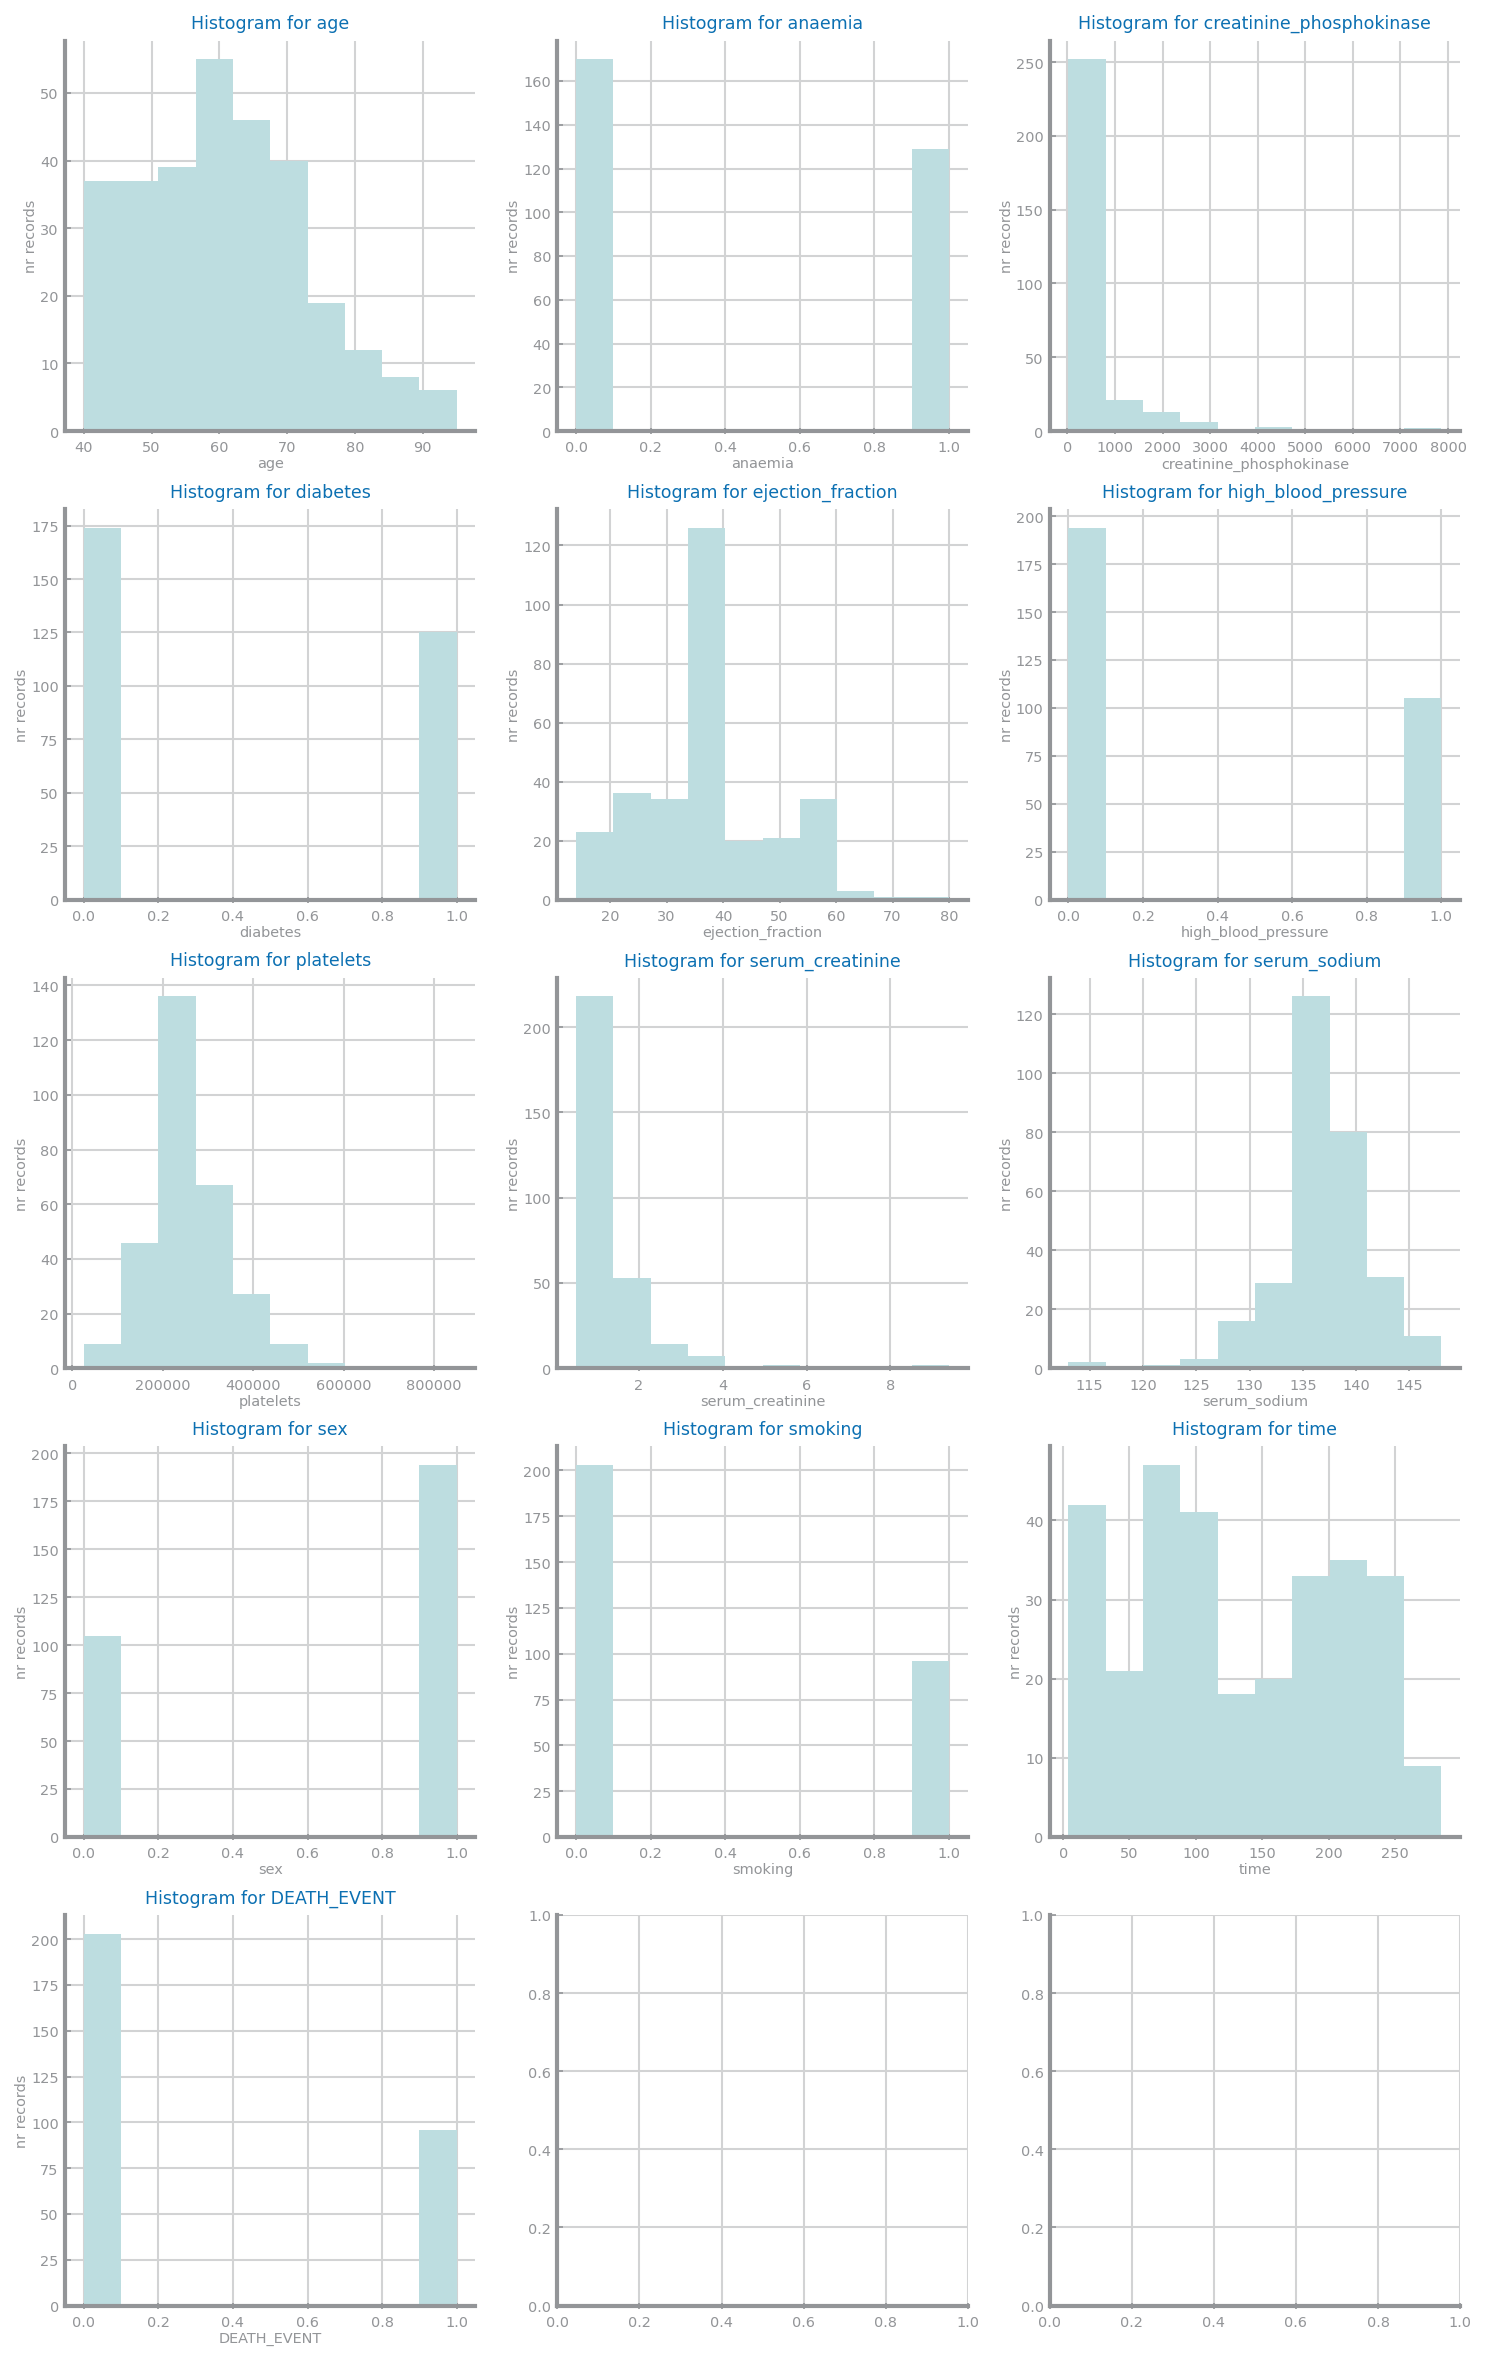

In [3]:
variables = data.select_dtypes(include='number').columns
rows, cols = ds.choose_grid(len(variables))
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
i, j = 0, 0
for n in range(len(variables)):
    axs[i, j].set_title('Histogram for %s'%variables[n])
    axs[i, j].set_xlabel(variables[n])
    axs[i, j].set_ylabel('nr records')
    axs[i, j].hist(data[variables[n]].values, bins=10)

    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    
plt.show()

This doesn't work all that well, especially for boolean variables. In order to work around this, let's select a number of bins which corresponds exactly to the different number of values a given variable may assume. This way boolean variables will have 2 bins and will be far easier to read. Furthermore, let's split this analysis between boolean and non-boolean values.

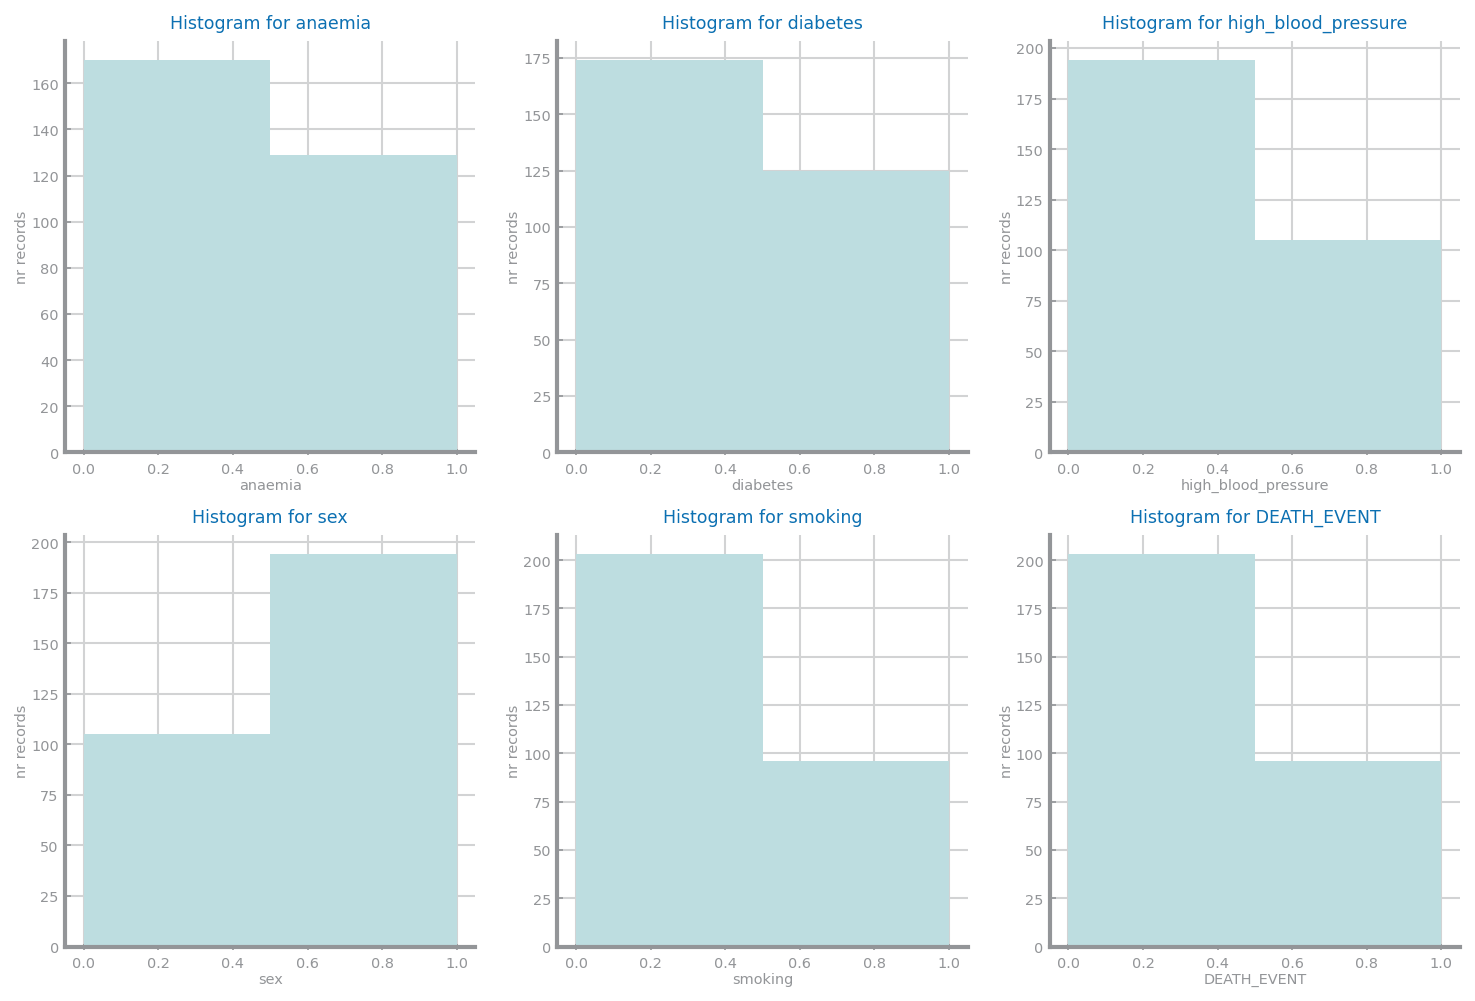

In [4]:
rows1, cols1 = ds.choose_grid(6)
fig2, axs2 = plt.subplots(rows1, cols1, figsize=(cols1*ds.HEIGHT, rows1*ds.HEIGHT))
i, j = 0, 0
for n in range(len(variables)):
    
    diff_vals = len(list(set(data[variables[n]].values)))

    if diff_vals != 2:
        continue
        
    axs2[i, j].set_title('Histogram for %s'%variables[n])
    axs2[i, j].set_xlabel(variables[n])
    axs2[i, j].set_ylabel('nr records')
    
    axs2[i, j].hist(data[variables[n]].values, bins=2)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    
plt.show()

Now that we have seen the distribution between boolean variables, let's exaime different levels of granularity for the remaining variables. In this case, we will consider the usage of 10, 50 and 100 bins.

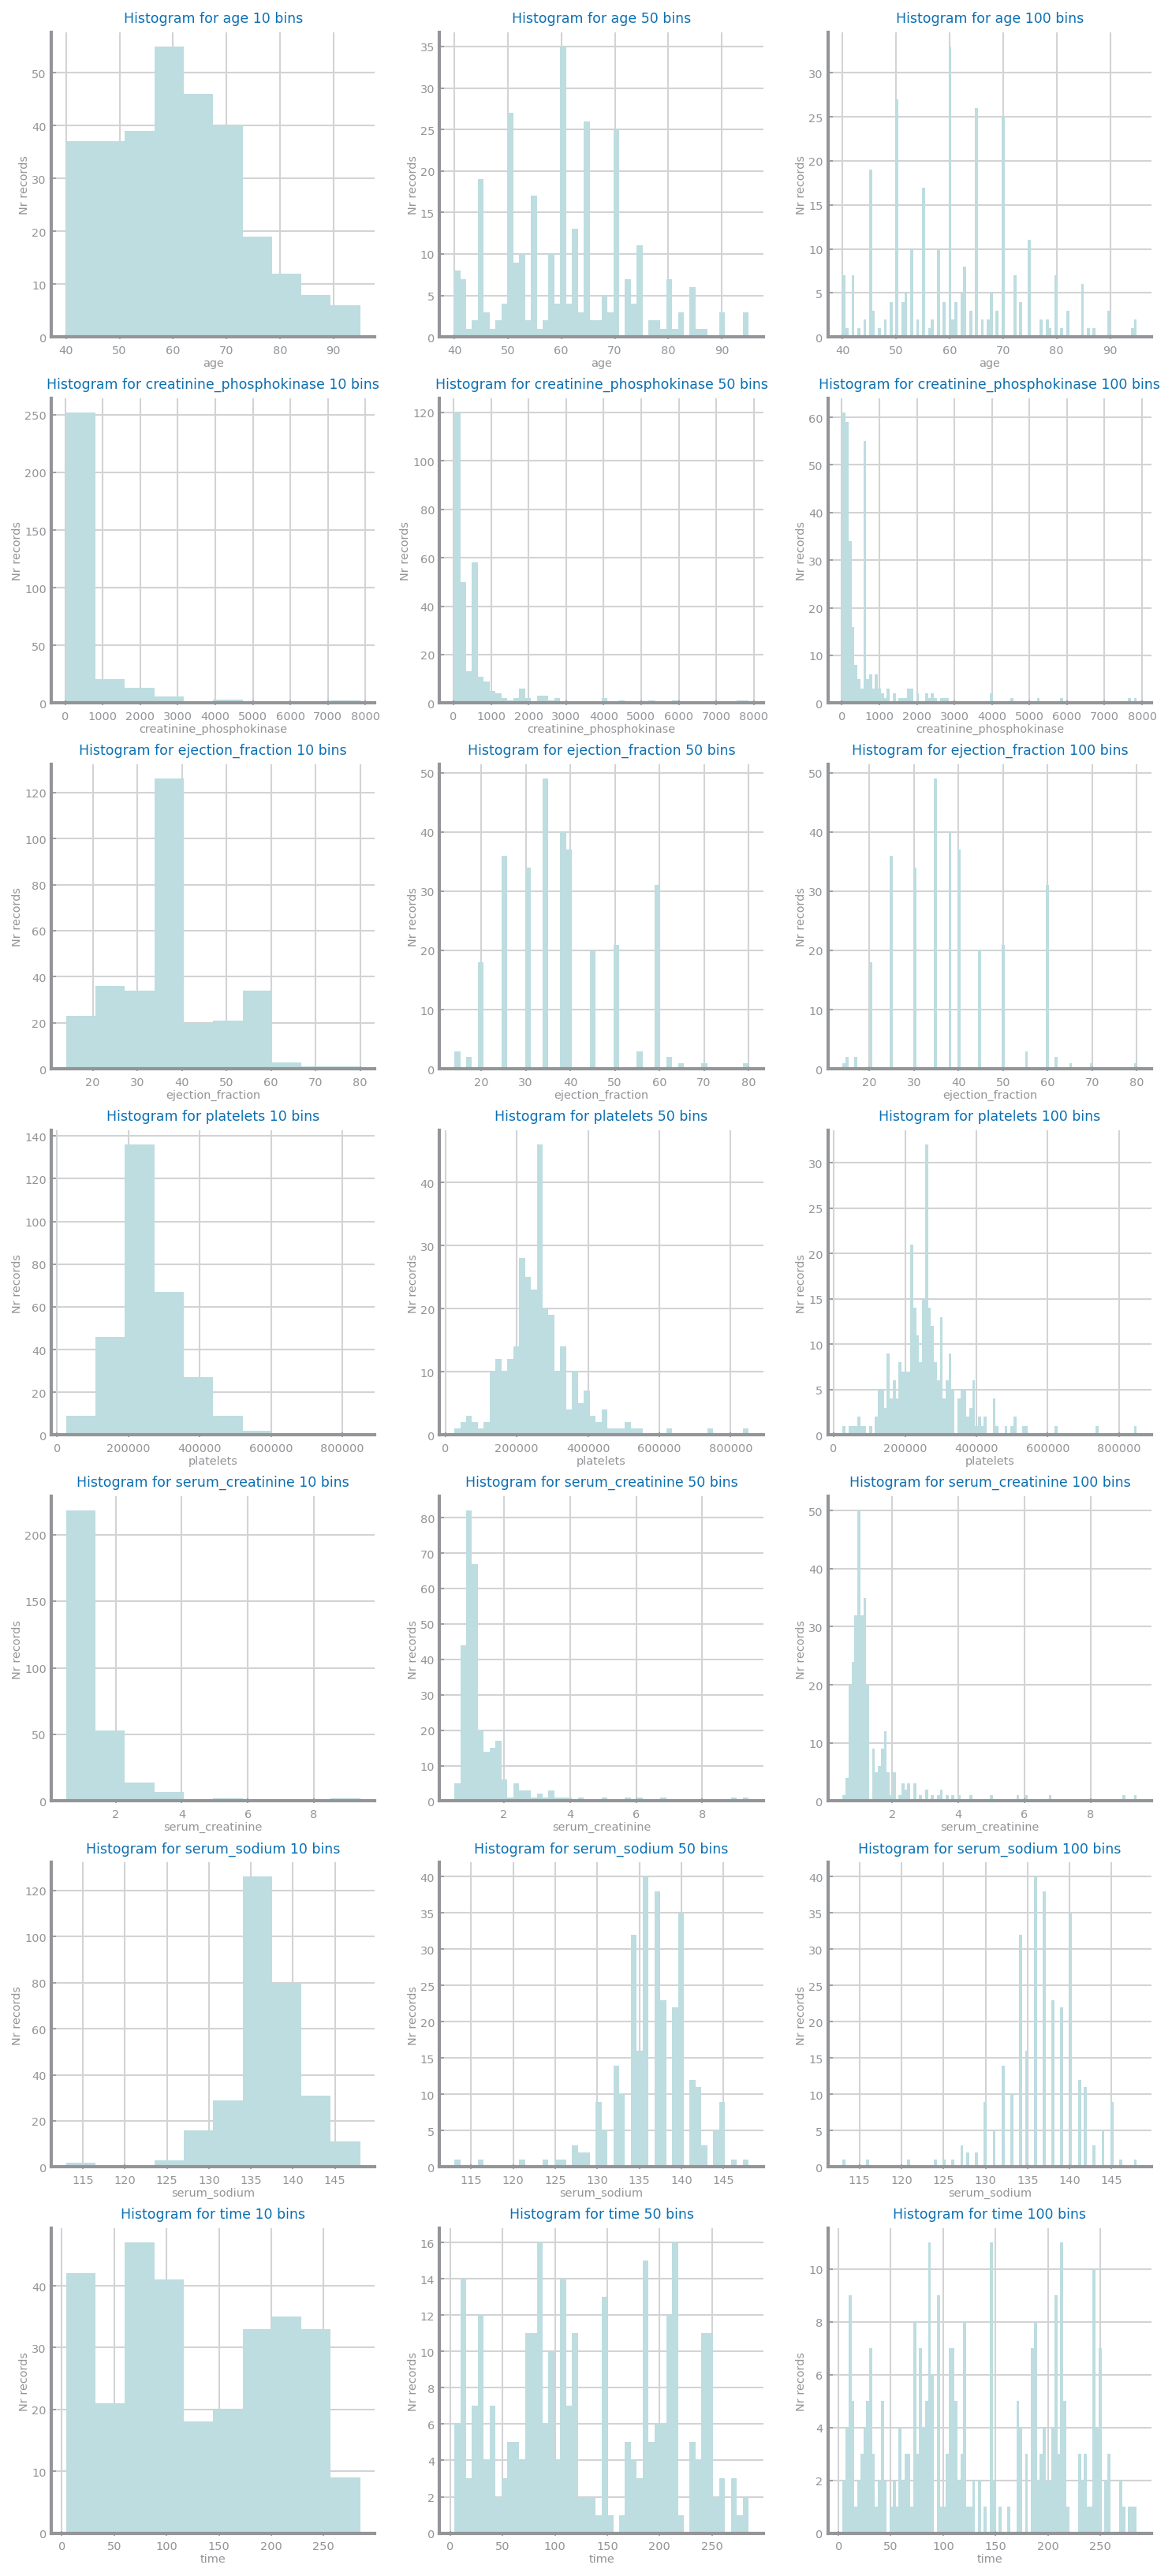

In [5]:
columns = data.select_dtypes(include='number').columns
rows = len(columns)
non_boolean_cols = 7
bins = (10, 50, 100)
cols = len(bins)
fig, axs = plt.subplots(non_boolean_cols, cols, figsize=(cols*ds.HEIGHT, non_boolean_cols*ds.HEIGHT))

iter_row, iter_col = 0, 0

for i in range(rows):
    
    diff_vals = len(list(set(data[variables[i]].values)))

    if diff_vals == 2:
        continue
        
    for j in range(cols):
        axs[iter_row, iter_col].set_title('Histogram for %s %d bins'%(columns[i], bins[j]))
        axs[iter_row, iter_col].set_xlabel(columns[i])
        axs[iter_row, iter_col].set_ylabel('Nr records')
        axs[iter_row, iter_col].hist(data[columns[i]].values, bins=bins[j])
        
        iter_row, iter_col = (iter_row + 1, 0) if (j+1) % cols == 0 else (iter_row, iter_col + 1)
        
plt.show()

### Summary
* **What is the most atomic granularity for each variable?**:
    * The finest granularity Boolean variables can have is individual True or False values, since they cannot be further split into deeper levels of detail.
    * Age, creatinine_phosphokinase, ejection_fraction (which is a percentage represented in integers), serum_sodium and time can be fully represented using a range of values (35-100, 0-8000, 0-100, 115-150 and 0-300, respectively). So, their finest granularity is the range of values they can assume.
    * As for the remaining values, since all of them refer to quantities per unit of measure, they can assume fractional values, which means the finest granularity in which they can be represented is gonna be the minimum difference between two sequenced values.
* **What is the best granularity to discretize each numeric variable?**
    * Age - finest granularity (range of all possible values)
    * Creatinine_phosphokinase -  50 bins seems like the best middle term between coarse and fine granularity.
    * Ejection_fraction - 50 bins
    * Platelets - 50 bins
    * Serum_creatinine - 100 bins. From looking at the histograms, the loss of information between 100 and 50 bins seems too much.
    * Serum_sodium - 50 bins
    * Time - Similarly to 'serum_creatinine', 100 bins
* **There are any hierarchy of concepts for symbolic variables, either from data or domain knowledge?**
    * Anaemia, high_blood_pressure and diabetes can all be aggregated into a coarser boolean variable: "diseased" which would be the result of the logical OR between all three variables.

## Oral Toxicity Dataset
This dataset is composed of 1024 boolean variables and a final boolean label that serves as the target variable. Since it's unfeasible to plot 1025 histograms and individually analyze the boolean distribution of each variable, let's group boolean variables by bins and perform the same analysis. In other words, instead of analyzing each of the 1025 variables, we'll be profiling blocks.

In [6]:
oral_data = pd.read_csv('../datasets/qsar_oral_toxicity.csv', sep=';', header=None)

oral_values = {'nr records': oral_data.shape[0], 'nr variables': oral_data.shape[1]}

# Naming columns to prevent errors
oral_data.columns = list(range(0, 1025))

oral_values

{'nr records': 8992, 'nr variables': 1025}

In [7]:
def sum_columns(df, start, end):
    ret = df[start].copy()
    
    if end > len(df):
        end = len(df)
        
    for i in range(start + 1, end):
        ret += df[i]
        
    return ret

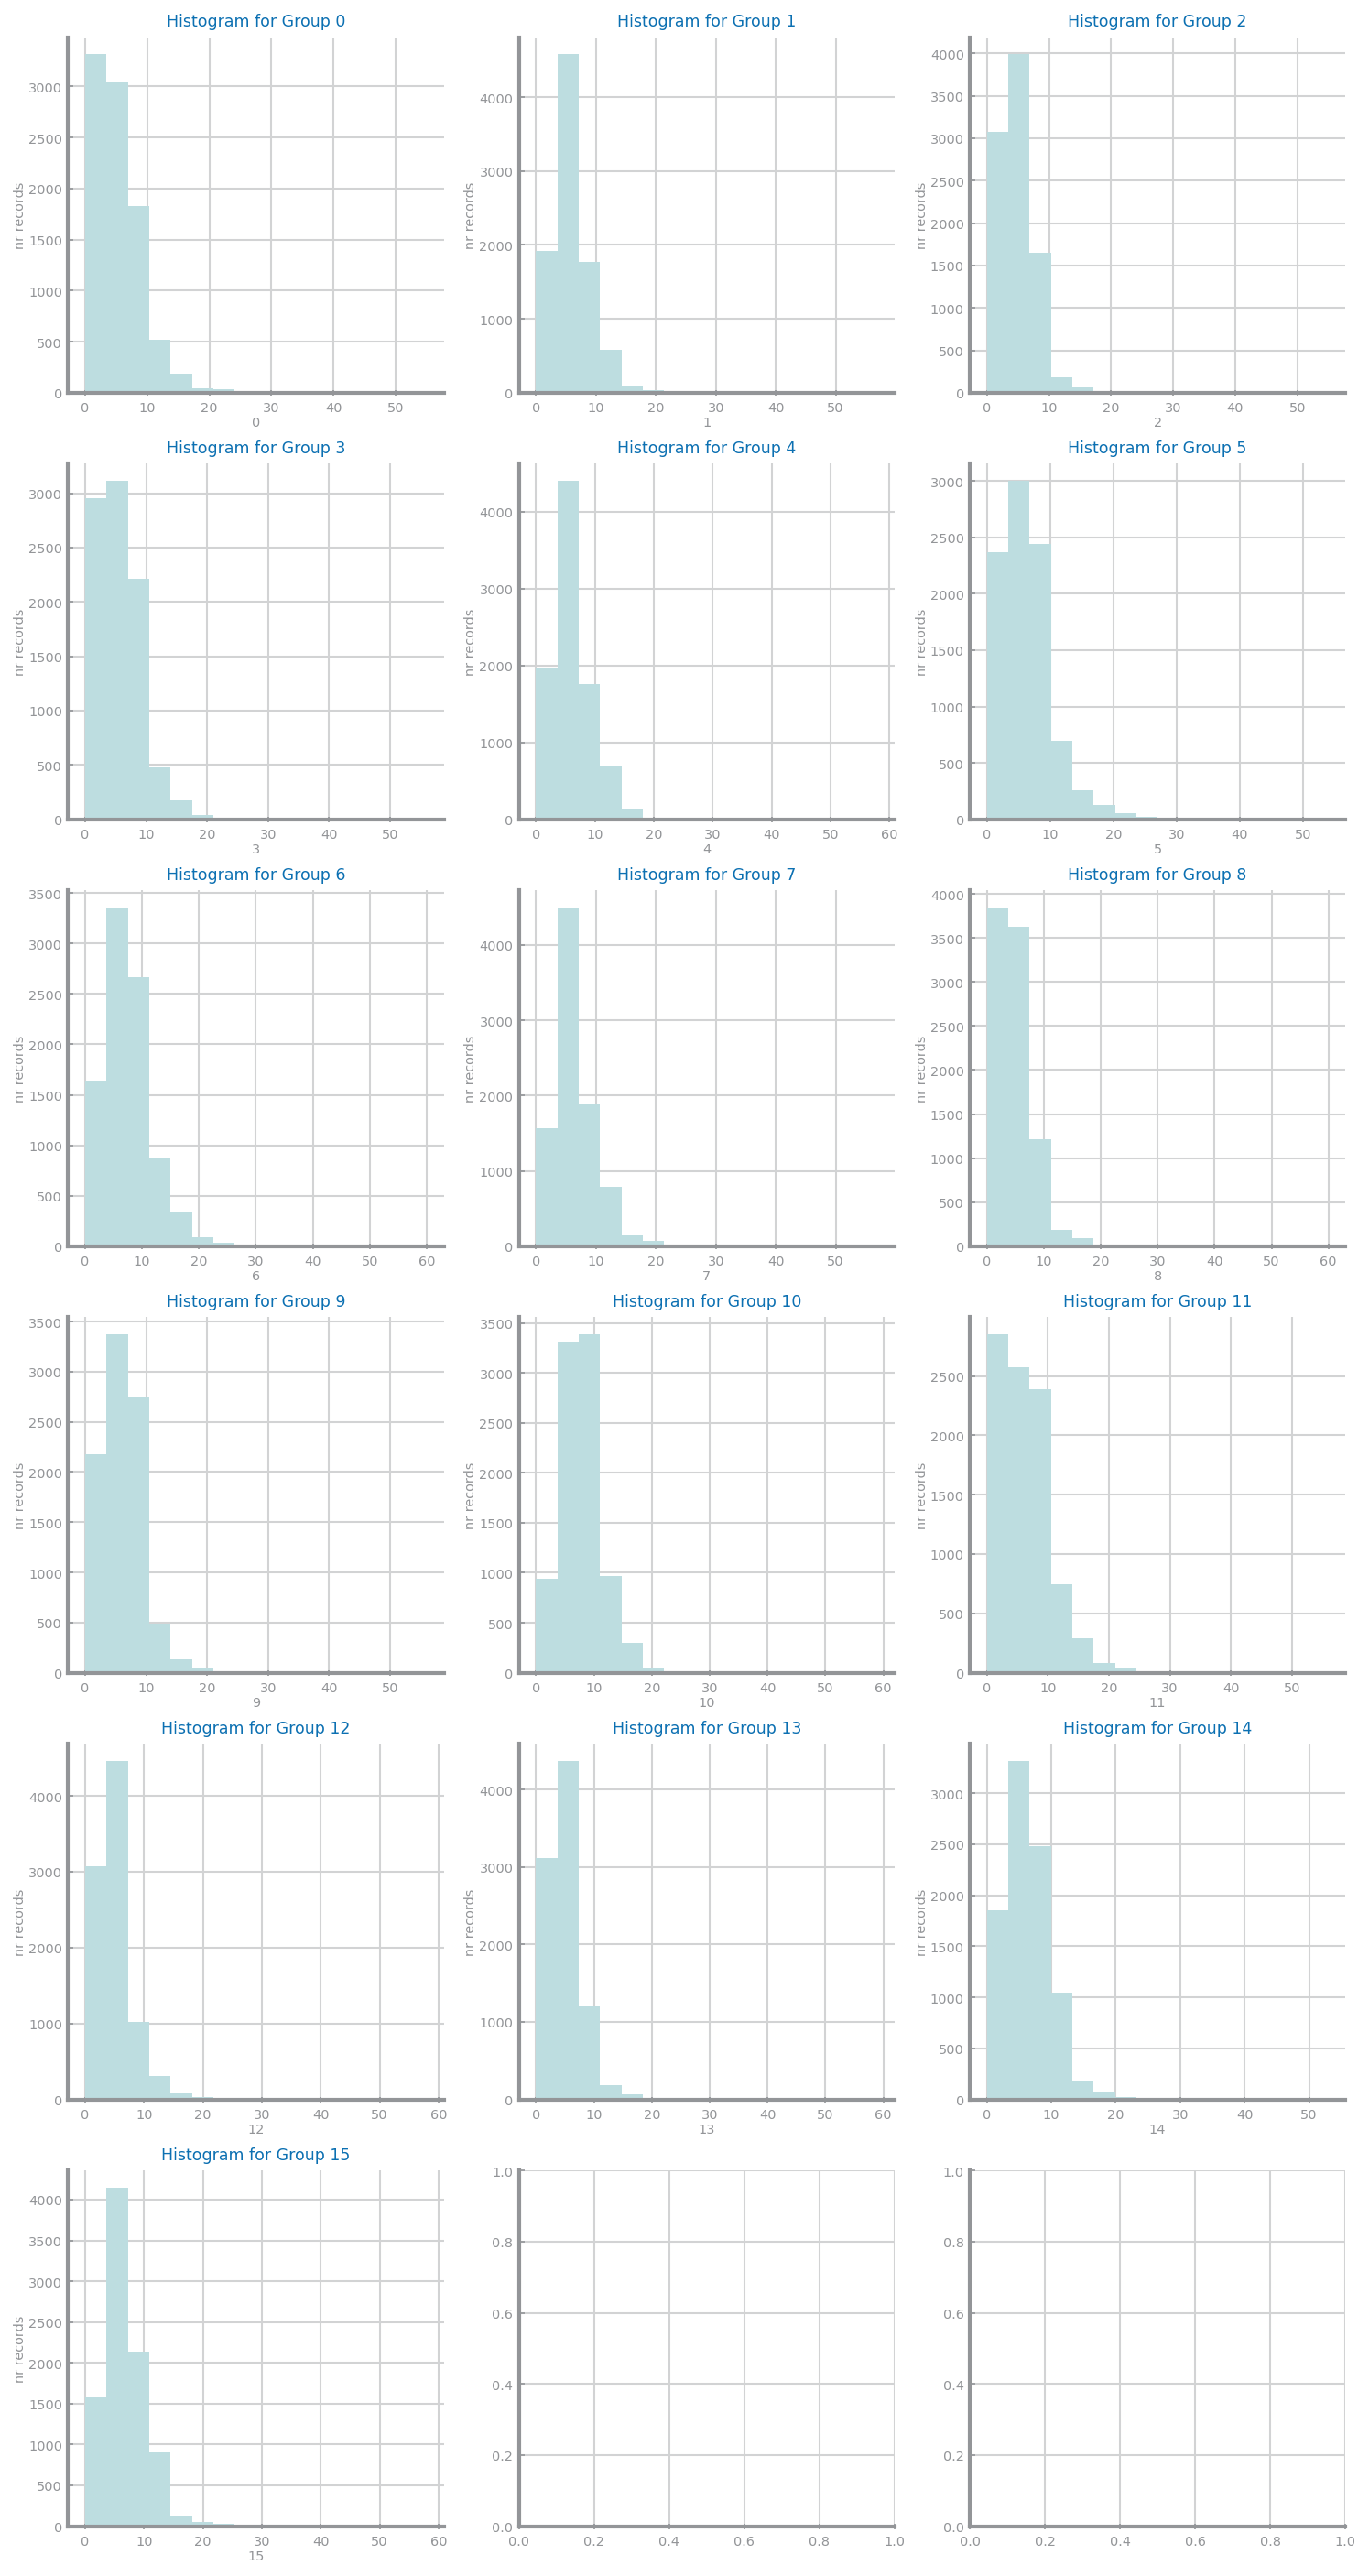

In [8]:
n_bins = 16 # grouping 64 variables per bin
group_size = int(1024 / n_bins)

variables = oral_data.select_dtypes(include='number').columns
rows, cols = ds.choose_grid(n_bins)
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
i, j = 0, 0
for n in range(n_bins):
    axs[i, j].set_title('Histogram for Group %s'%variables[n])
    axs[i, j].set_xlabel(variables[n])
    axs[i, j].set_ylabel('nr records')
        
    group = sum_columns(oral_data, n * group_size, (n + 1) * group_size)
    axs[i, j].hist(group, bins=n_bins)

    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    
plt.show()

### Summary
* **What is the most atomic granularity for each variable?**:
    * As mentioned before, the finest granularity Boolean variables can have is individual True or False values, since they cannot be further split into deeper levels of detail.
sequenced values.
* **What is the best granularity to discretize each numeric variable?**
    * This dataset displays no numeric variables
* **There are any hierarchy of concepts for symbolic variables, either from data or domain knowledge?**
    * We can group boolean variables.